In [1]:
import pandas as pd
import sqlite3
import shlex
import numpy as np
import collections
from matplotlib import pyplot as pl
import matplotlib.cm as cm
from ast import literal_eval

%matplotlib inline

def auto_cast(s):
    try:
        return int(s)
    except ValueError:
        try:
            return float(s)
        except ValueError:
            if s.lower() in ["false", "true"]:
                try:
                    return bool(s)
                except ValueError:
                    pass
    return str(s)

def cmd_parser(s, sort=False, template_dict=None):
    if '.py' in s:
        s = s.split('.py')[1]
    res = [x.split('=') if '=' in x else x.split(' ') for x in s.split(' --')[1:]]
    res = dict([(x[0], auto_cast(x[1])) if len(x) == 2 else (x[0], True) for x in res])
    if template_dict is not None:
        template_dict.update(res)
        res = template_dict        
    if sort:
        return collections.OrderedDict(sorted(res.items()))
    else:
        return res

def get_optimal_df(leave_out, optimal_params, df):
    df_res = df
    print len(df_res)
    for param, val in optimal_params.iteritems():
        if not param == leave_out:
            df_res = df_res[df_res[param] == val]
            print len(df_res)
    return df_res

eval_metrics = [ 'score',
                 'train_loss',
                 'reg_loss',
                 'estimated_error',
                 'centroid_norm',
                 'emb_norm',
                 'k_score',
                 'svm_score'
               ]

In [2]:
# Establish DB connection
conn = sqlite3.connect("/usr/stud/plapp/runnn2/runnn_data")
df = pd.read_sql_query("select * from tasks where score > 0;", conn)  # where status is 'done' and changed > '2017-11-05'
conn.close()
print("Loaded %d rows." % len(df))

conn = sqlite3.connect("/usr/stud/plapp/runnn_data_aws")
df2 = pd.read_sql_query("select * from tasks where score > 0;", conn)  # where status is 'done' and changed > '2017-11-05'
conn.close()
print("Loaded %d rows." % len(df2))

df2.ID_task += 10000

df = pd.concat([df, df2], ignore_index=True)
print("Final: %d rows." % len(df))

df

Loaded 3442 rows.
Loaded 524 rows.
Final: 3966 rows.


,ID_task,ID_run,ID_client,cmd,params,status,log,changed,min_mem,score,train_loss,reg_loss,estimated_error,centroid_norm,emb_norm,k_score,svm_score
0,1,1,atcremers79,python3 ~/lba_tf/semisup/train_unsup2.py --re...,"{'init_method': 'normal_center03', 'visit_weig...",done,2017-11-08 17:04:18.137375: W tensorflow/core/...,2017-11-08 16:20:51,0,0.960600,7.2389,0.2450,0.9959,5.3104,4.7866,0.9653,0.9800
1,2,1,hpccremers1,python3 ~/lba_tf/semisup/train_unsup2.py --re...,"{'volta': False, 'trafo_weight': 0, 'decay_ste...",done,2017-11-08 17:04:33.399177: W tensorflow/core/...,2017-11-08 16:22:40,0,0.965900,7.2286,0.2432,0.9960,5.2246,4.7911,0.9661,0.9785
2,3,1,hpccremers1,python3 ~/lba_tf/semisup/train_unsup2.py --re...,"{'shuffle_augmented_samples': False, 'num_augm...",done,2017-11-08 17:04:43.716018: W tensorflow/core/...,2017-11-08 16:22:23,0,0.948000,7.2172,0.2521,0.9956,5.4012,4.8173,0.9506,0.9709
3,4,1,hpccremers3,python3 ~/lba_tf/semisup/train_unsup2.py --re...,"{'volta': False, 'walker_weight': 1.0, 'restor...",done,2017-11-08 17:20:41.503468: W tensorflow/core/...,2017-11-08 16:37:54,0,0.889100,7.2138,0.2468,0.9977,4.6036,4.3059,0.8872,0.9789
4,5,1,hpccremers3,python3 ~/lba_tf/semisup/train_unsup2.py --re...,"{'rvisit_weight': 1, 'cluster_association_weig...",done,2017-11-08 17:20:50.846821: W tensorflow/core/...,2017-11-08 16:37:55,0,0.973300,7.2201,0.2409,0.9964,4.6678,4.2871,0.7471,0.9850
5,6,1,hpccremers3,python3 ~/lba_tf/semisup/train_unsup2.py --re...,"{'optimizer': 'adam', 'emb_size': 64, 'decay_f...",done,2017-11-08 17:21:02.871715: W tensorflow/core/...,2017-11-08 16:37:51,0,0.771800,7.2107,0.2393,0.9934,4.7741,4.2861,0.7712,0.9672
6,7,1,atcremers79,python3 ~/lba_tf/semisup/train_unsup2.py --re...,"{'logit_weight': 0.5, 'decay_steps': 5000.0, '...",done,2017-11-08 17:21:05.126945: W tensorflow/core/...,2017-11-08 16:38:17,0,0.621400,7.2078,0.2494,0.9943,4.8830,4.2836,0.5876,0.9472
7,9,1,hpccremers1,python3 ~/lba_tf/semisup/train_unsup2.py --re...,"{'warmup_steps': 1000, 'decay_factor': 0.33, '...",done,2017-11-08 17:22:38.672136: W tensorflow/core/...,2017-11-08 16:41:08,0,0.908400,7.2052,0.2414,0.9929,4.6035,4.3557,0.9080,0.9732
8,10,1,hpccremers1,python3 ~/lba_tf/semisup/train_unsup2.py --re...,"{'scale_match_ab': 1, 'restore_checkpoint': No...",done,2017-11-08 17:22:55.585709: W tensorflow/core/...,2017-11-08 16:41:10,0,0.886200,7.2182,0.2390,0.9935,4.6086,4.3380,0.7496,0.9806
9,13,4,atcremers14,python3 ~/lba_tf/semisup/train_unsup2.py --nu...,"{'decay_steps': 5000.0, 'l1_weight': 0.0, 'shu...",done,2017-11-08 18:17:40.533990: W tensorflow/core/...,2017-11-08 17:42:21,0,0.127200,6.8227,0.4455,0.9745,4.3030,2.5102,0.1424,0.1508


In [3]:
# Turn hyperparams into columns
hyperparams_df = df['params'].apply(literal_eval).apply(pd.Series)
params = hyperparams_df.columns.tolist()
df = df.join(hyperparams_df)

In [4]:
# Get list of datasets
datasets = [x for x in df.dataset.unique() if x == x]

In [5]:
print 'LEADERBOARD'
use_latest = 0
best_params_per_dataset = dict()
for dataset in datasets:
    ddf = df[df.dataset == dataset][-use_latest:]
    score_mean = ddf.score.mean() * 100
    score_std = ddf.score.std() * 100
    score_max = ddf.score.max() * 100
    score_max_taskid = ddf.ID_task[ddf.score.argmax()]
    print "%s:\t\t%.2f%%\t+/- %.2f (%d runs)\tbest: %.2f%% @ task %d" % (dataset[:6], score_mean, score_std, len(ddf), score_max, score_max_taskid)
    best_params_per_dataset[dataset] = df[df.ID_task == score_max_taskid][['ID_task'] + params].to_dict('list')

LEADERBOARD
mnist:		45.71%	+/- 35.92 (3096 runs)	best: 99.07% @ task 1812
svhn:		24.61%	+/- 9.21 (776 runs)	best: 52.40% @ task 10586
cifar_:		22.31%	+/- 7.90 (44 runs)	best: 34.07% @ task 4107
stl10:		44.97%	+/- 2.27 (50 runs)	best: 49.81% @ task 10042


In [6]:
df

,ID_task,ID_run,ID_client,cmd,params,status,log,changed,min_mem,score,...,trafo_separate_loss_collection,trafo_weight,unsup_batch_size,use_test,virtual_embeddings_per_class,visit_weight_add,visit_weight_base,volta,walker_weight,warmup_steps
0,1,1,atcremers79,python3 ~/lba_tf/semisup/train_unsup2.py --re...,"{'init_method': 'normal_center03', 'visit_weig...",done,2017-11-08 17:04:18.137375: W tensorflow/core/...,2017-11-08 16:20:51,0,0.960600,...,NaN,0.000000e+00,100,NaN,4,0,1.0,False,1.0,1000
1,2,1,hpccremers1,python3 ~/lba_tf/semisup/train_unsup2.py --re...,"{'volta': False, 'trafo_weight': 0, 'decay_ste...",done,2017-11-08 17:04:33.399177: W tensorflow/core/...,2017-11-08 16:22:40,0,0.965900,...,NaN,0.000000e+00,100,NaN,4,0,1.0,False,1.0,1000
2,3,1,hpccremers1,python3 ~/lba_tf/semisup/train_unsup2.py --re...,"{'shuffle_augmented_samples': False, 'num_augm...",done,2017-11-08 17:04:43.716018: W tensorflow/core/...,2017-11-08 16:22:23,0,0.948000,...,NaN,0.000000e+00,100,NaN,4,0,1.0,False,1.0,1000
3,4,1,hpccremers3,python3 ~/lba_tf/semisup/train_unsup2.py --re...,"{'volta': False, 'walker_weight': 1.0, 'restor...",done,2017-11-08 17:20:41.503468: W tensorflow/core/...,2017-11-08 16:37:54,0,0.889100,...,NaN,0.000000e+00,100,NaN,4,0,1.0,False,1.0,1000
4,5,1,hpccremers3,python3 ~/lba_tf/semisup/train_unsup2.py --re...,"{'rvisit_weight': 1, 'cluster_association_weig...",done,2017-11-08 17:20:50.846821: W tensorflow/core/...,2017-11-08 16:37:55,0,0.973300,...,NaN,0.000000e+00,100,NaN,4,0,1.0,False,1.0,1000
5,6,1,hpccremers3,python3 ~/lba_tf/semisup/train_unsup2.py --re...,"{'optimizer': 'adam', 'emb_size': 64, 'decay_f...",done,2017-11-08 17:21:02.871715: W tensorflow/core/...,2017-11-08 16:37:51,0,0.771800,...,NaN,0.000000e+00,100,NaN,4,0,1.0,False,1.0,1000
6,7,1,atcremers79,python3 ~/lba_tf/semisup/train_unsup2.py --re...,"{'logit_weight': 0.5, 'decay_steps': 5000.0, '...",done,2017-11-08 17:21:05.126945: W tensorflow/core/...,2017-11-08 16:38:17,0,0.621400,...,NaN,0.000000e+00,100,NaN,4,0,1.0,False,1.0,1000
7,9,1,hpccremers1,python3 ~/lba_tf/semisup/train_unsup2.py --re...,"{'warmup_steps': 1000, 'decay_factor': 0.33, '...",done,2017-11-08 17:22:38.672136: W tensorflow/core/...,2017-11-08 16:41:08,0,0.908400,...,NaN,0.000000e+00,100,NaN,4,0,1.0,False,1.0,1000
8,10,1,hpccremers1,python3 ~/lba_tf/semisup/train_unsup2.py --re...,"{'scale_match_ab': 1, 'restore_checkpoint': No...",done,2017-11-08 17:22:55.585709: W tensorflow/core/...,2017-11-08 16:41:10,0,0.886200,...,NaN,0.000000e+00,100,NaN,4,0,1.0,False,1.0,1000
9,13,4,atcremers14,python3 ~/lba_tf/semisup/train_unsup2.py --nu...,"{'decay_steps': 5000.0, 'l1_weight': 0.0, 'shu...",done,2017-11-08 18:17:40.533990: W tensorflow/core/...,2017-11-08 17:42:21,0,0.127200,...,NaN,1.000000e+00,100,NaN,4,0,0.5,False,1.0,1000


In [7]:
print("Average best hyper params for all data sets")
average_top_num = 10
best_params = dict([(x, []) for x in params])
best_params_var = dict([(x, []) for x in params])
for dataset in datasets:
    best = df[df.dataset == dataset].score.sort_values()[-average_top_num:]
    best = df.iloc[best.index]
    #print(dataset)
    for param in params:
        try:
            #print('\t%s:\t%f (%f)' % (param, best[param].mean(), best[param].std()))
            best_params[param].append(best[param].mean())
        except TypeError:
            pass #print(' %s: %s' % (param, best[param]))
    print
    
params_to_delete = []
for p, v in best_params.iteritems():
    if v and not np.any(np.isnan(v)):
        best_params[p] = np.mean(v)
        best_params_var[p] = np.std(v)
    else:
        params_to_delete.append(p)
for p in params_to_delete:
    del best_params[p]
    del best_params_var[p]
best_params

Average best hyper params for all data sets






{'beta1': 0.75,
 'beta2': 0.93600000000000017,
 'centroid_momentum': 0.0,
 'cluster_association_weight': 1.0,
 'cluster_hardening_weight': 0.040266503000000002,
 'decay_factor': 0.33000000000000002,
 'decay_steps': 10025.0,
 'dropout_keep_prob': 0.89749999999999996,
 'emb_size': 78.400000000000006,
 'eval_interval': 1000.0,
 'init_with_kmeans': 1.0,
 'l1_weight': 0.0,
 'learning_rate': 0.00086000000000000009,
 'logit_entropy_weight': 0.010300257749999998,
 'logit_weight': 0.5,
 'max_steps': 36550.0,
 'norm_target': 3.0,
 'norm_weight': 4.1625000000000009e-05,
 'normalize_embeddings': 0.0,
 'normalize_input': 1.0,
 'num_augmented_samples': 3.6499999999999999,
 'num_blocks': 3.375,
 'num_unlabeled_images': 31250.0,
 'reg_association_weight': 0.90749999999999997,
 'reg_decay_factor': 0.38750000000000007,
 'reg_warmup_steps': 4812.5,
 'rvisit_weight': 1.0,
 'rwalker_weight': 1.0,
 'scale_match_ab': 1.0,
 'shuffle_augmented_samples': 0.0,
 'svm_test_interval': 10000.0,
 'trafo_weight': 2.68

In [8]:
print('Variances of the best hps over the data sets')
best_params_var

Variances of the best hps over the data sets


{'beta1': 0.045825756949558434,
 'beta2': 0.011022703842524266,
 'centroid_momentum': 0.0,
 'cluster_association_weight': 0.0,
 'cluster_hardening_weight': 0.069130111377322598,
 'decay_factor': 0.0,
 'decay_steps': 3663.5877224382111,
 'dropout_keep_prob': 0.054025456962435867,
 'emb_size': 21.406541056415442,
 'eval_interval': 0.0,
 'init_with_kmeans': 0.0,
 'l1_weight': 0.0,
 'learning_rate': 8.6023252670426248e-05,
 'logit_entropy_weight': 0.017154731304693759,
 'logit_weight': 0.0,
 'max_steps': 16808.55436972496,
 'norm_target': 0.0,
 'norm_weight': 3.2072914975100101e-05,
 'normalize_embeddings': 0.0,
 'normalize_input': 0.0,
 'num_augmented_samples': 0.16583123951776996,
 'num_blocks': 0.72240916383999443,
 'num_unlabeled_images': 54126.587736527414,
 'reg_association_weight': 0.14889173919328097,
 'reg_decay_factor': 0.12676257334087221,
 'reg_warmup_steps': 1911.2741169178219,
 'rvisit_weight': 0.0,
 'rwalker_weight': 0.0,
 'scale_match_ab': 0.0,
 'shuffle_augmented_samples':

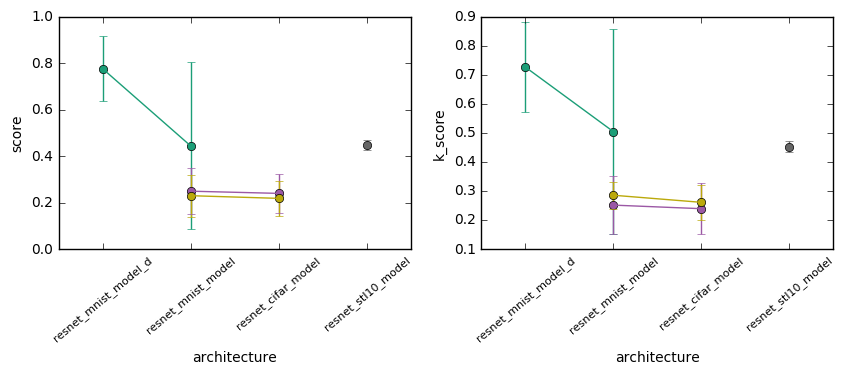

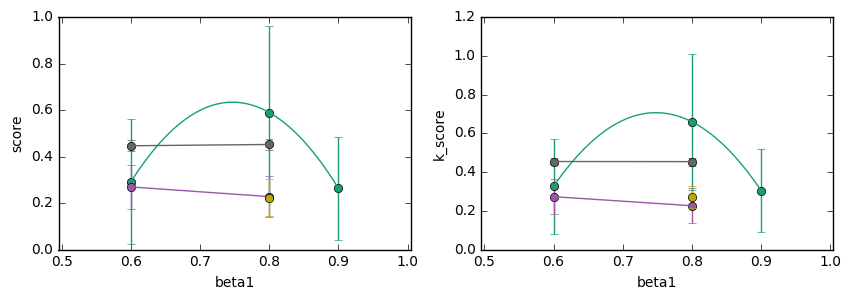

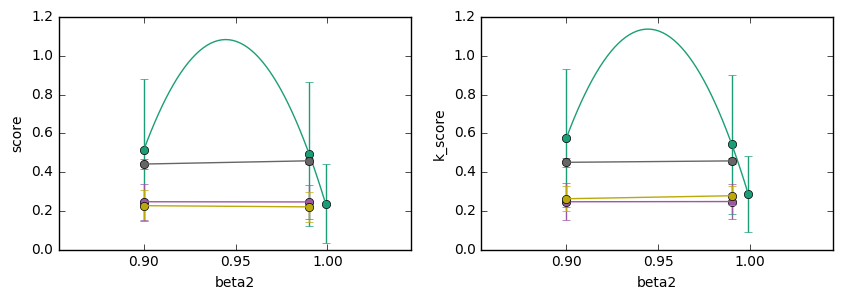

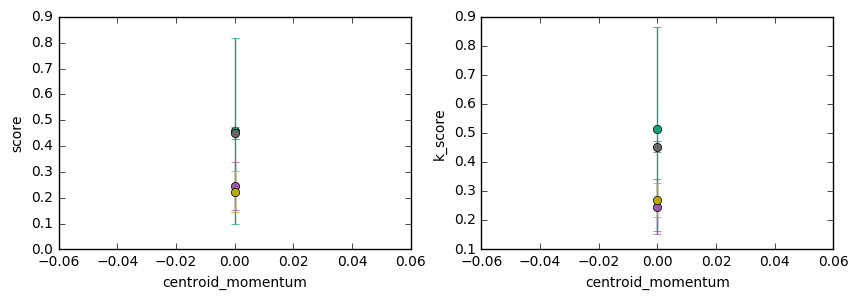

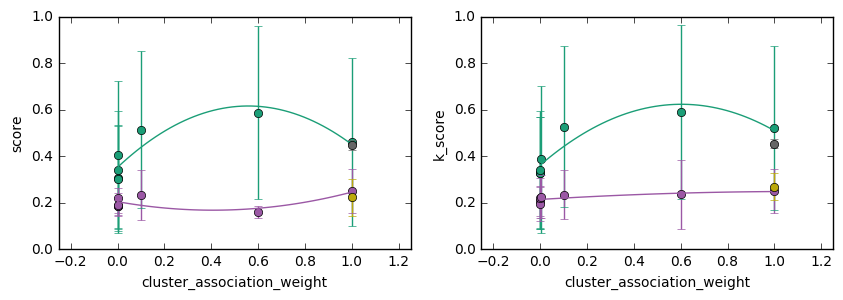

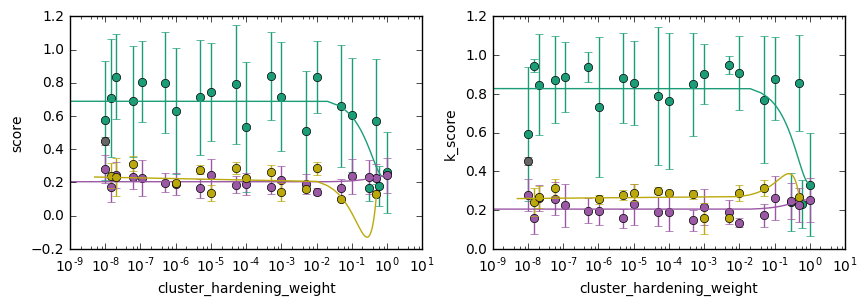

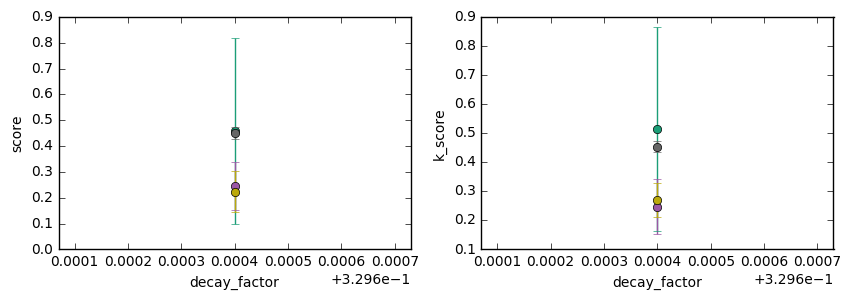

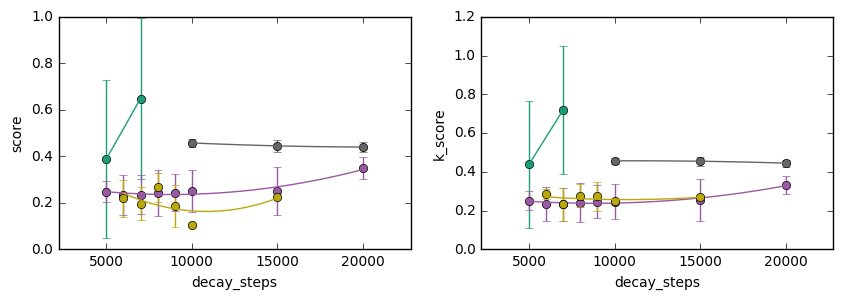

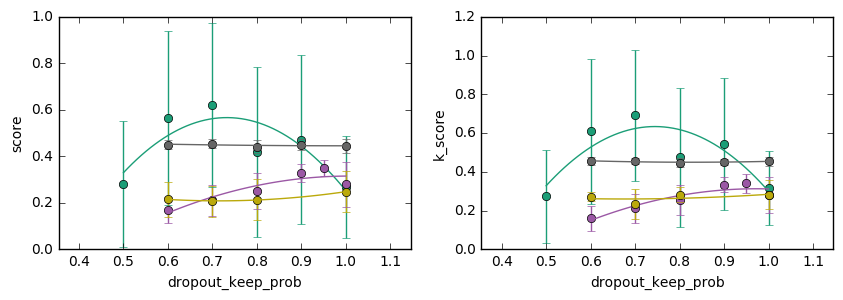

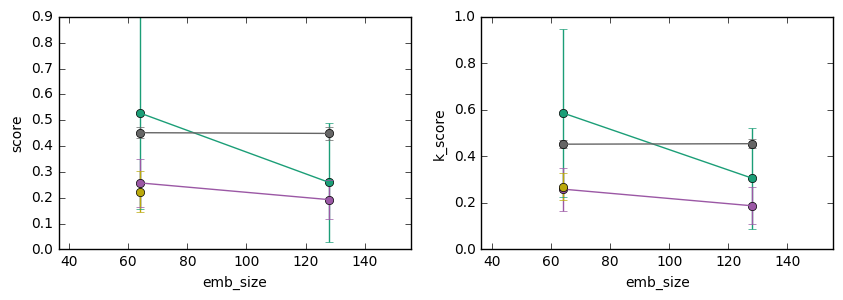

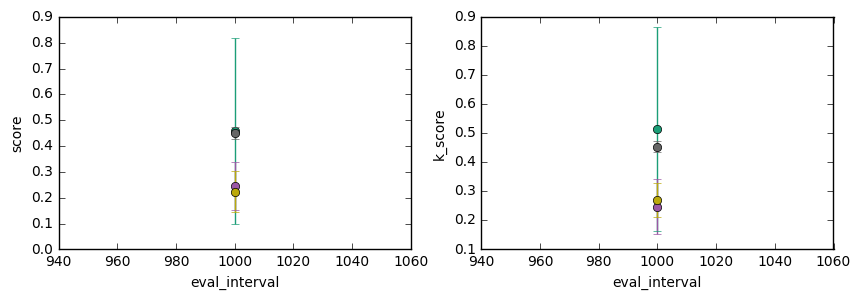

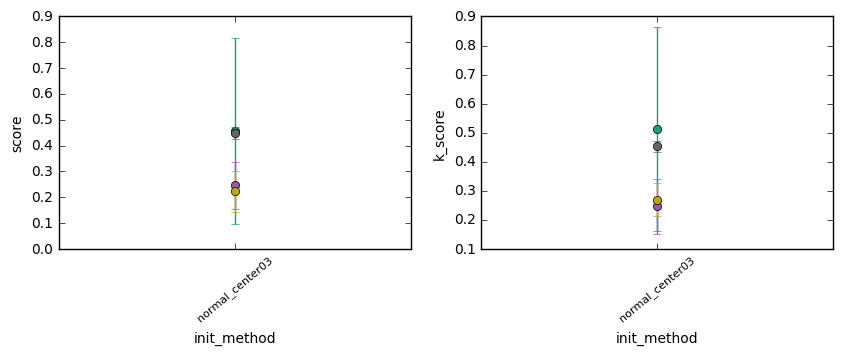

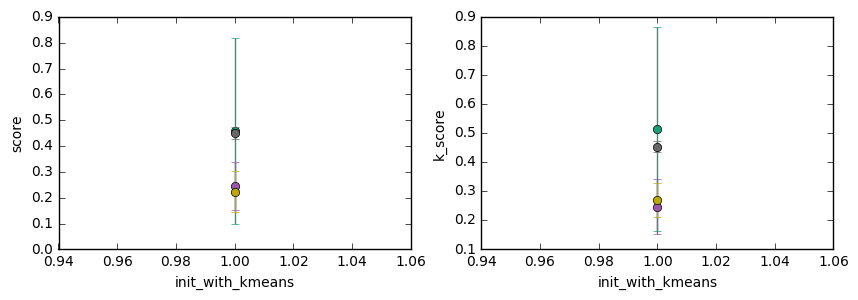

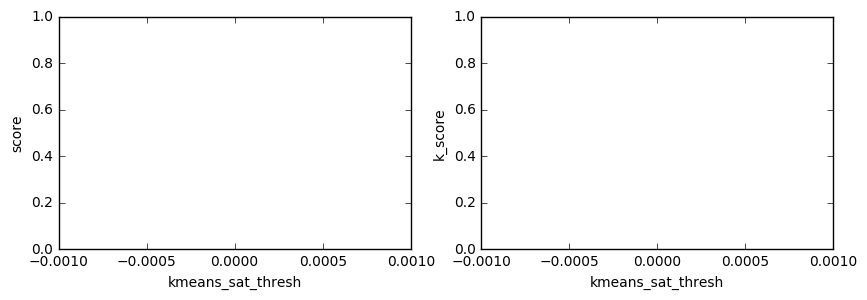

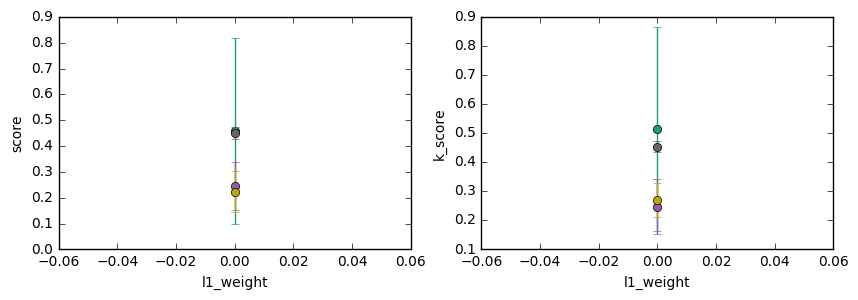

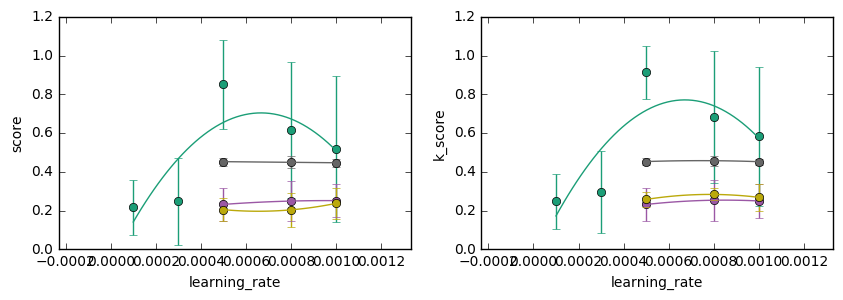

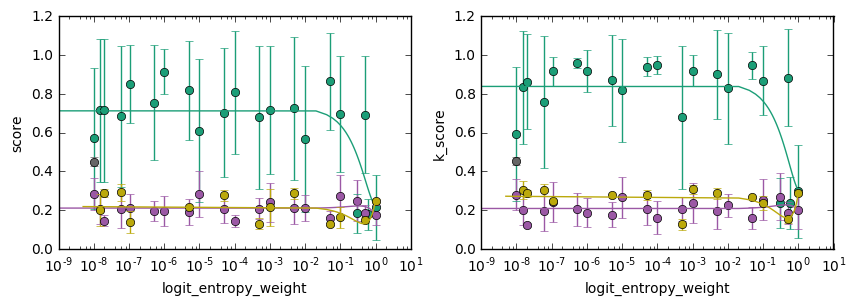

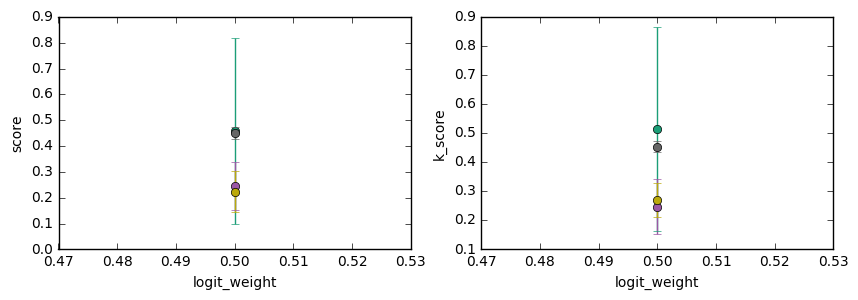

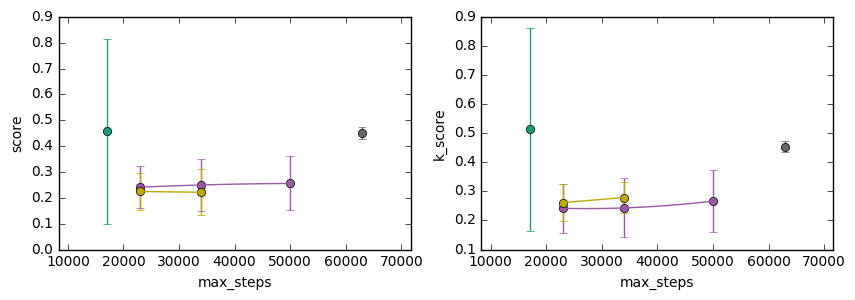

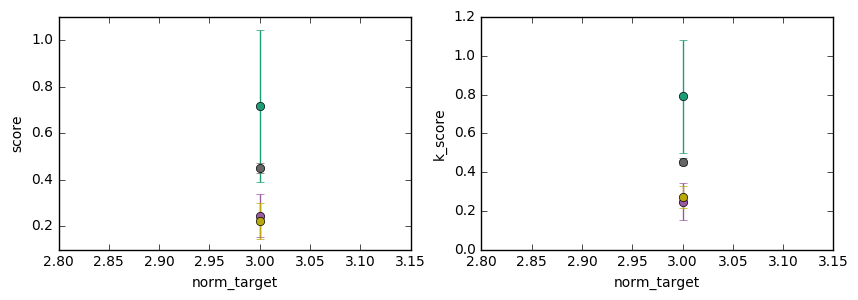

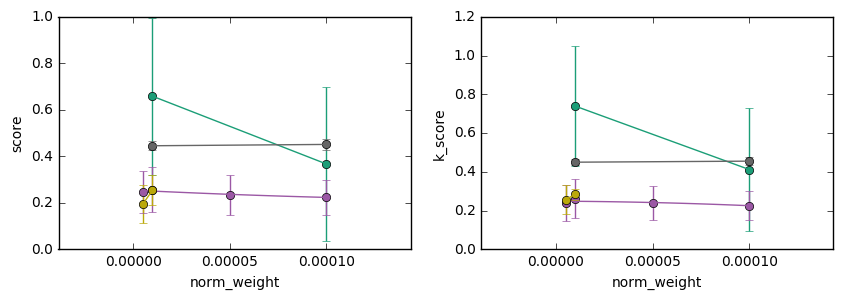

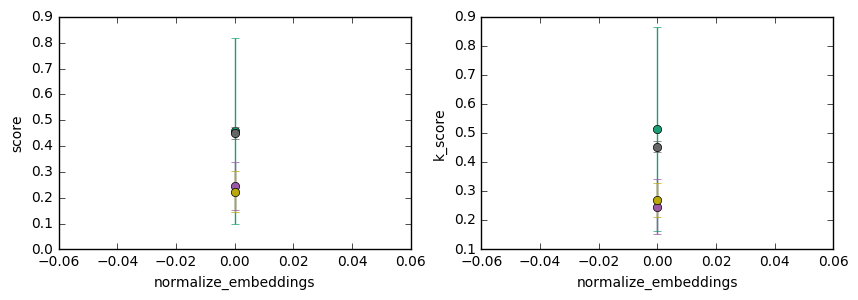

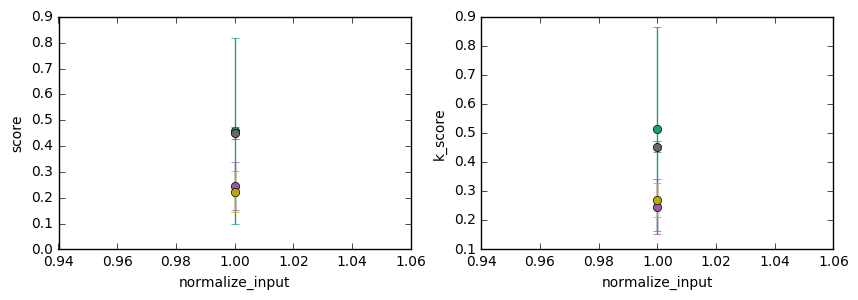

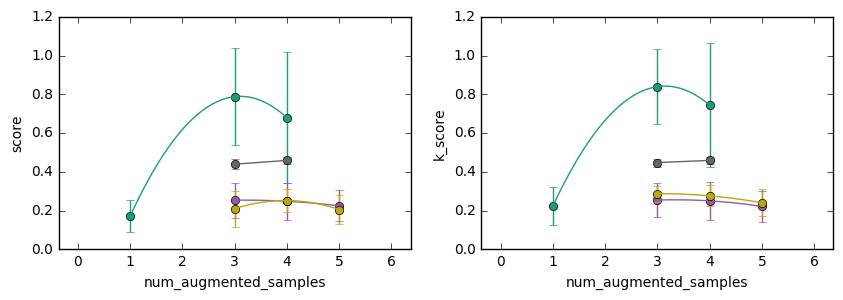

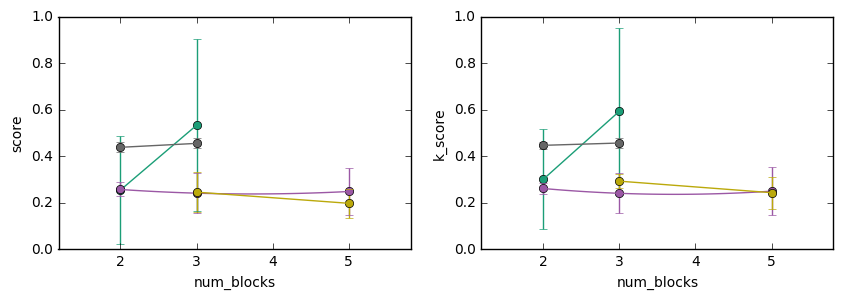

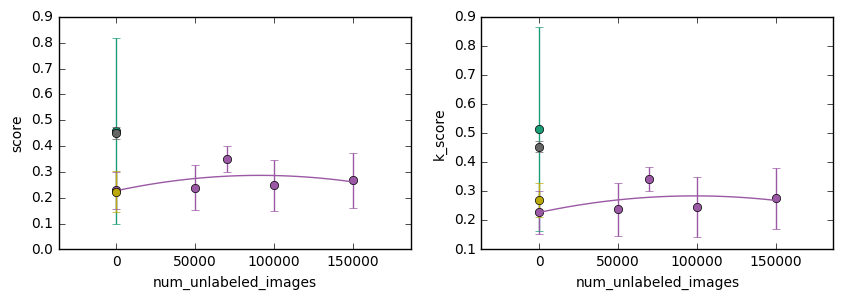

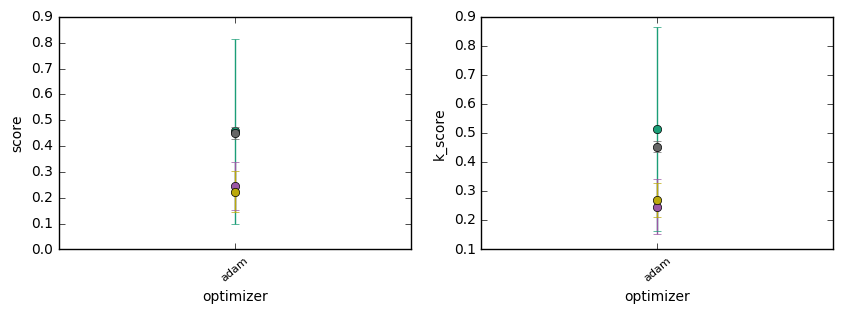

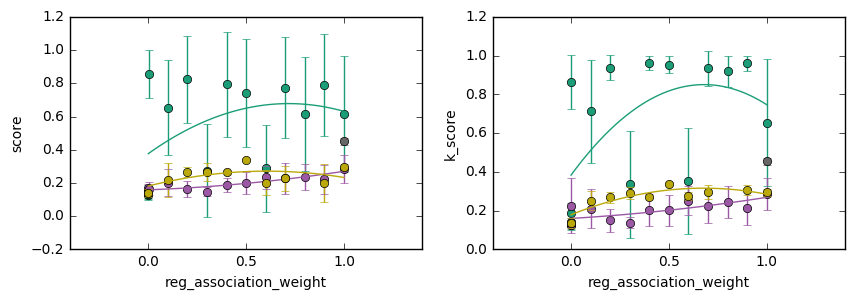

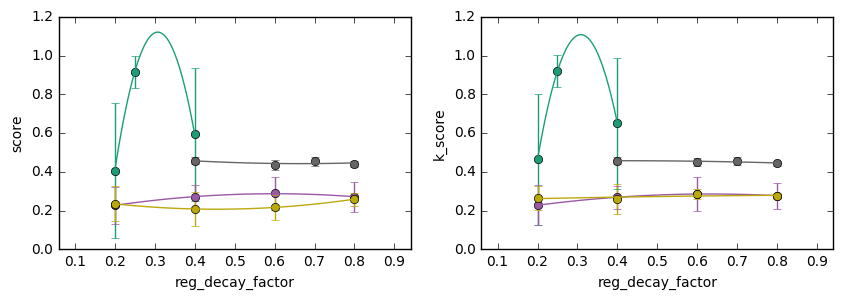

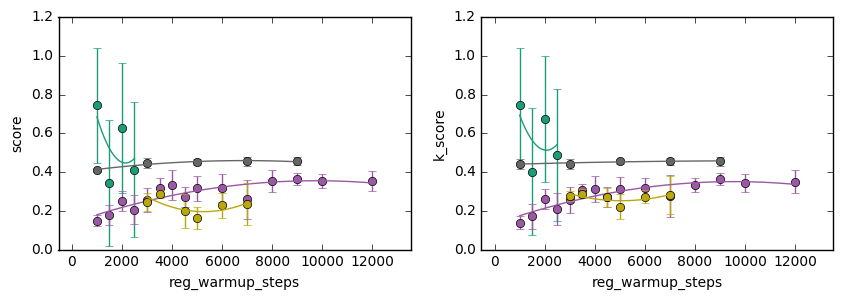

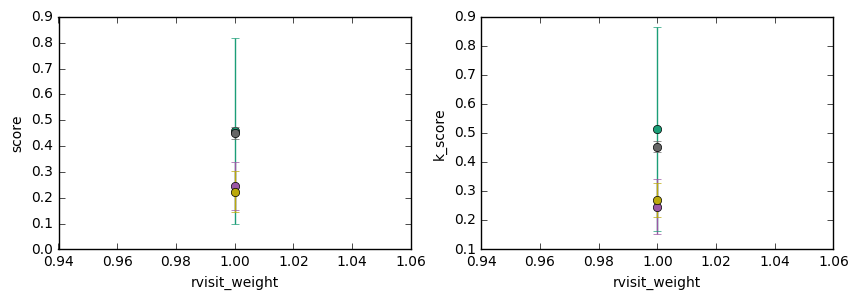

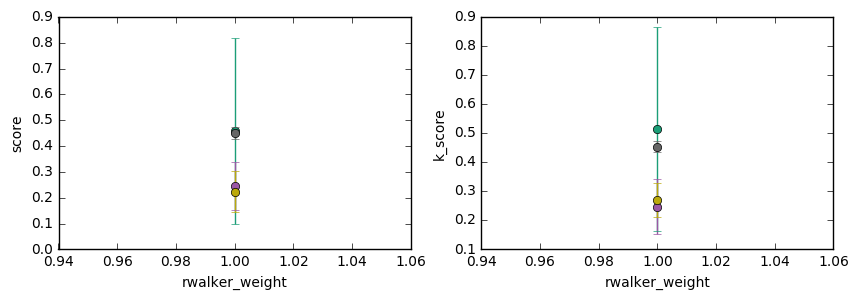

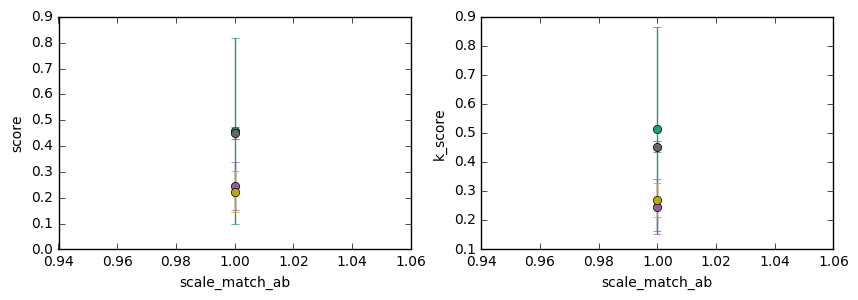

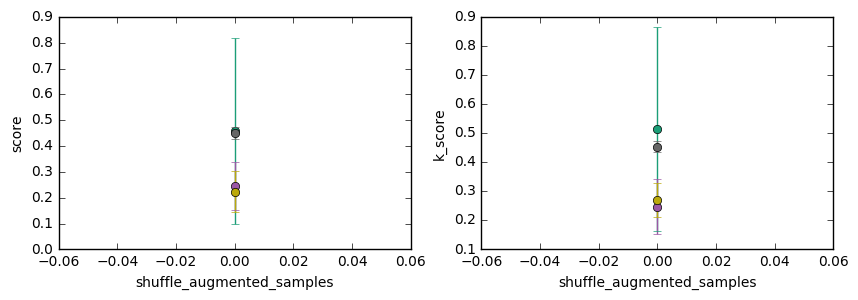

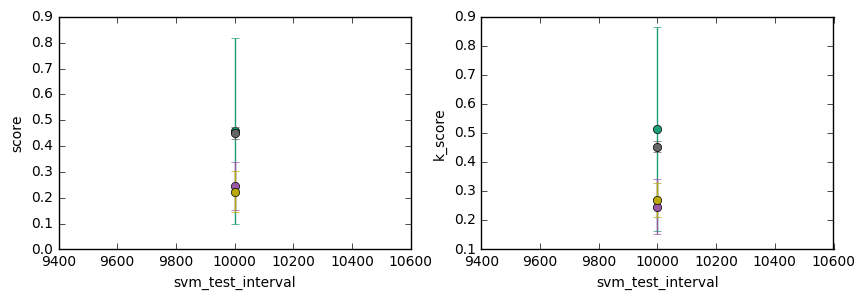

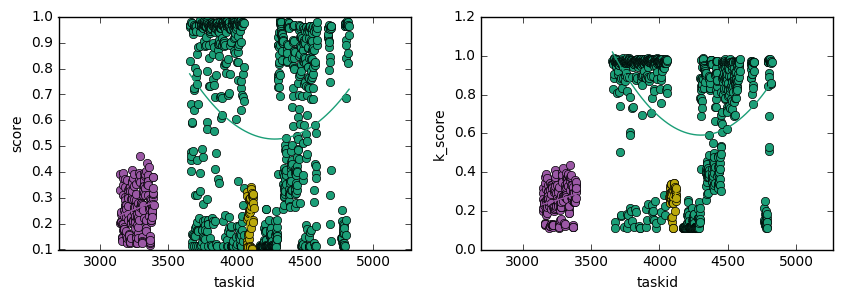

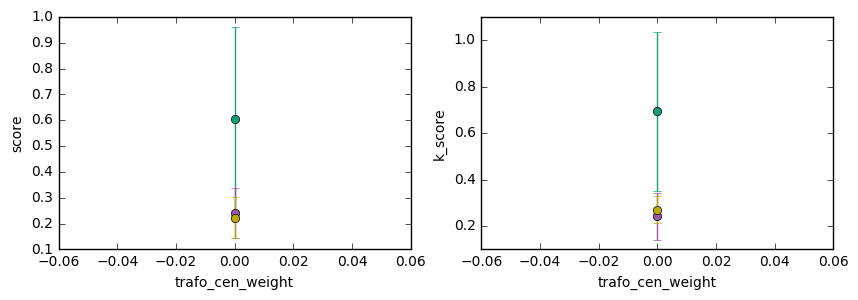

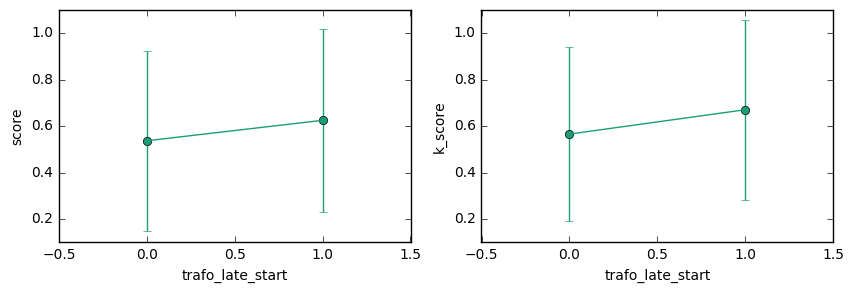

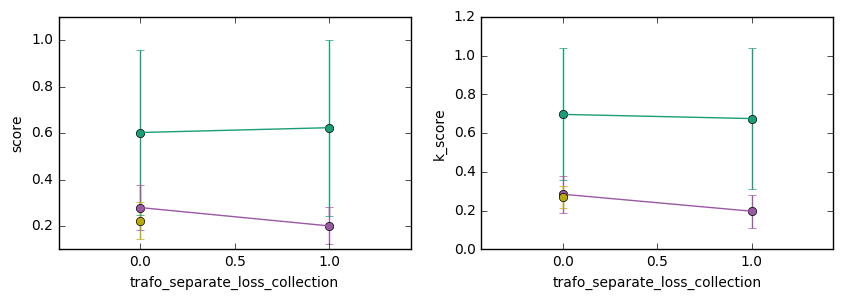

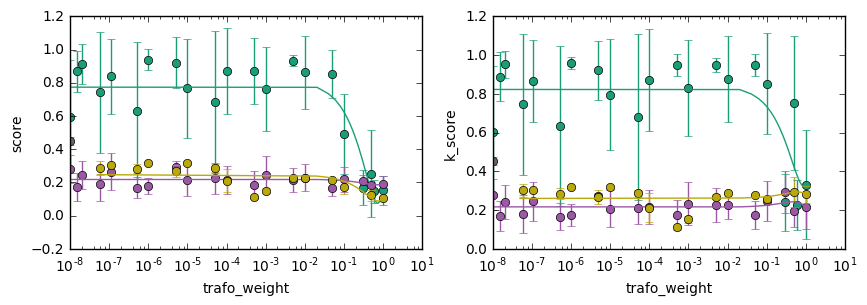

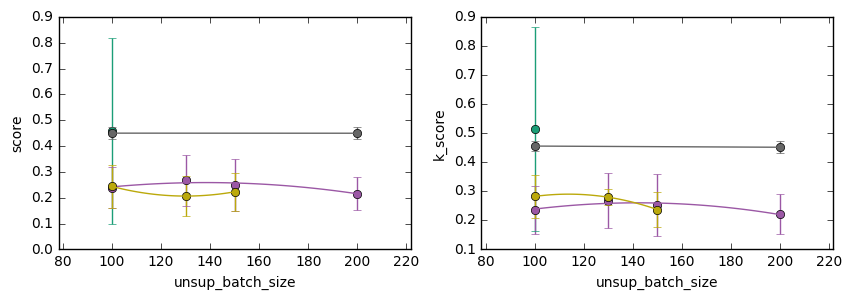

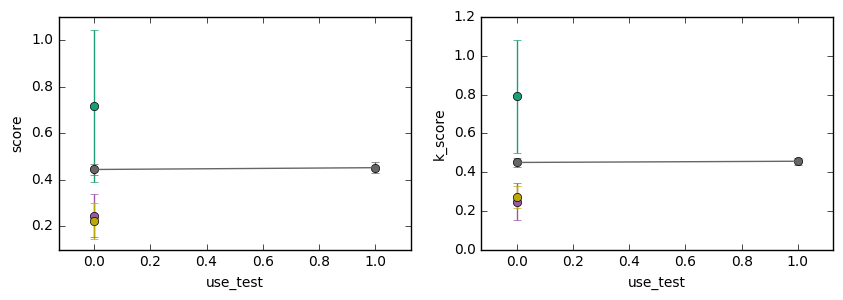

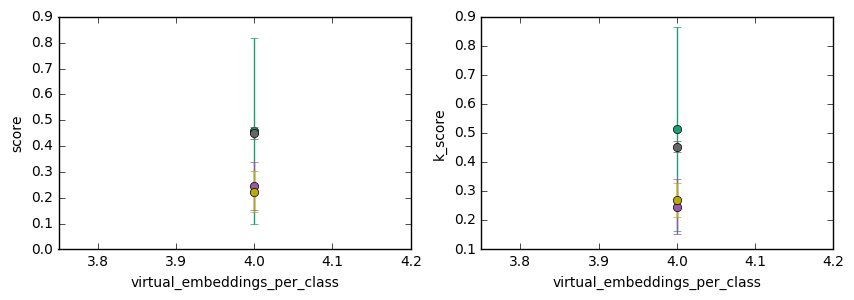

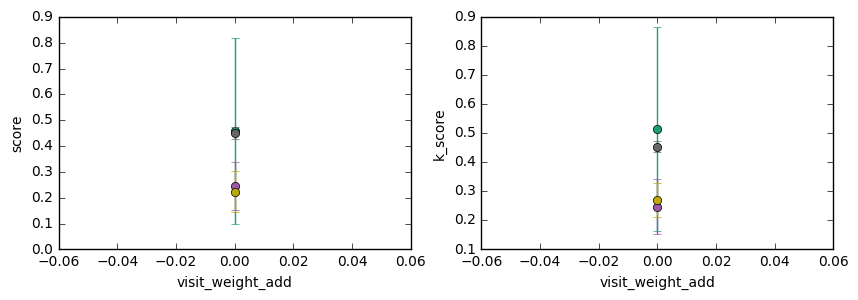

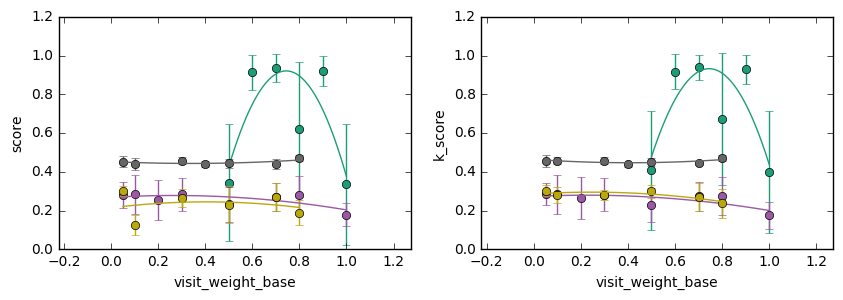

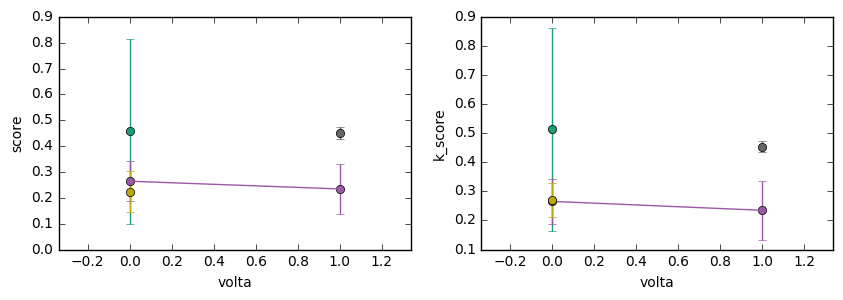

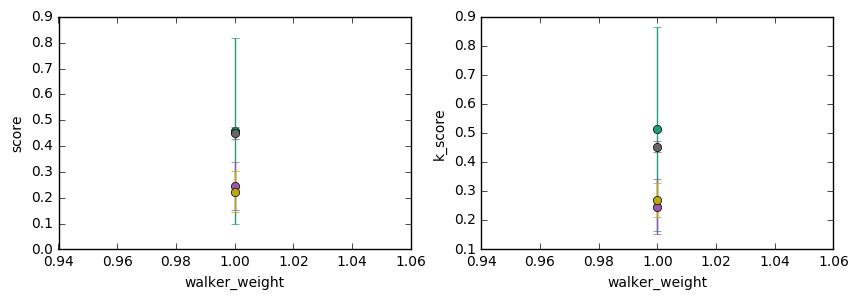

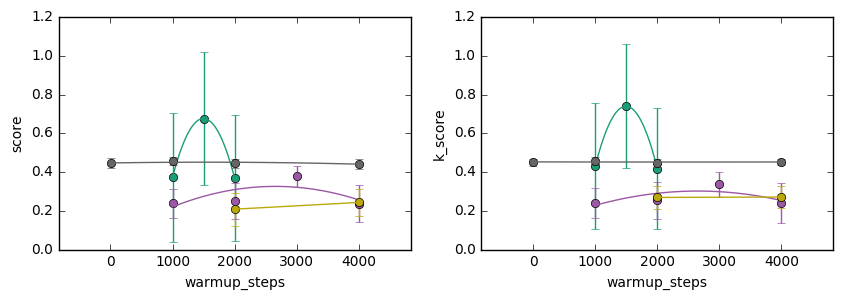

In [9]:
# Ablation study
not_plot = ['dataset', 'logdir', 'restore_checkpoint']
use_latest = 0  # how many runs to consider; 0=all
metrics_to_plot = ['score', 'k_score'] #eval_metrics
eval_against_optimal_params = False  # vary only param at hand, fix all others to optimum
needs_log_scale = ['logit_entropy_weight', 'trafo_weight', 'cluster_hardening_weight']

if eval_against_optimal_params:
    # Find optimal params
    optimal_params = dict()
    for p in params:
        if not p in not_plot:
            optimal_params[p] = df.pivot_table('score', columns=[p]).argmax()

for param in params:
    if param in not_plot:
        continue
        
    is_numeric = True
    try:
        df[param].astype(float)
    except ValueError:
        is_numeric = False
    
    if is_numeric:
        xstd = df[param].std()
        xmin = df[param].min()-xstd
        xmax = df[param].max()+xstd
    else:
        xlabels = [i for i in df[param].unique() if i==i]  # remove nans
        label_to_x = dict([(j,i) for (i,j) in enumerate(xlabels)])
        xmin = -0.5
        xmax = len(xlabels) - 0.5

    colors = iter(cm.Dark2(np.linspace(0, 1, len(datasets))))

    fig, axs = pl.subplots(1, len(metrics_to_plot), figsize=(10,3))
    for dataset in datasets: 
        ddf = df[df.dataset == dataset][-use_latest:]
        if eval_against_optimal_params:
            ddf = get_optimal_df(param, optimal_params, ddf)
        label = "%s (%d runs)" % (dataset, len(ddf))
        c = next(colors)
        
        xs = ddf[param].unique() 
        xs = [i for i in xs if i==i]  # remove nans
        
        if not is_numeric:
            xs_ = []
            for x in xs:
                xval = label_to_x[x]
                xs_.append(xval)
            xs = xs_

        
        for ax, metric_to_plot in enumerate(metrics_to_plot):
            ys = []
            for x in xs:
                if is_numeric:
                    y = ddf[ddf[param] == x][metric_to_plot].astype(float)
                else:
                    y = ddf[ddf[param] == xlabels[x]][metric_to_plot].astype(float)
                yerr = y.std()
                y = y.mean()
                ys.append(y)
                
                if param in needs_log_scale:
                    x += 1e-8
                axs[ax].errorbar(x, y, yerr=yerr, label=label, color=c, marker='o')

            if not xmin == xmax and not param in needs_log_scale:
                axs[ax].set_xlim((xmin, xmax))

            if not is_numeric:
                axs[ax].set_xticks(range(len(xlabels)), minor=False)
                axs[ax].set_xticklabels(xlabels, minor=False, rotation=40, fontsize=8)
               
            if len(xs) > 1: 
                deg = np.clip(len(xs)-1, 1, 2)
                pf = np.polyfit(xs, ys, deg)
                pf = np.poly1d(pf)
                xp = np.linspace(np.min(xs), np.max(xs), 50)
                axs[ax].plot(xp, pf(xp), color=c)

            # fix legend
            handles, labels = axs[ax].get_legend_handles_labels()
            newLabels, newHandles = [], []
            for handle, label in zip(handles, labels):
                if label not in newLabels:
                    newLabels.append(label)
                    newHandles.append(handle)
            #axs[ax].legend(newHandles, newLabels, loc='best', fontsize=8)
            
            axs[ax].set_xlabel(param)
            axs[ax].set_ylabel(metric_to_plot)
            if param in needs_log_scale:
                axs[ax].set_xscale("log")
    pl.show()